In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
import lightning as L
import matplotlib.pyplot as plt
from transphorm.model_components import SyntheticTSDataModule
from pathlib import Path
import seaborn as sns

from transphorm.model_components.model_modules import Encoder, Decoder, VanillaAutoEncoder
import polars as pl

from pyts.decomposition import SingularSpectrumAnalysis
from sklearn.preprocessing import StandardScaler 
import numpy as np

In [3]:
fp_data = pl.read_parquet('/Volumes/fsmresfiles/Basic_Sciences/Phys/Lerner_Lab_tnl2633/Gaby/MetaData_ForMike/aggregated_data.parquet.gzp')
fp_data

mouse_id,day,event,sensor,time,trial,signal,__index_level_0__
str,i64,str,str,f32,i32,f32,i64
"""142_237""",1,"""avoid""","""D1""",-25.0,0,0.955051,0
"""142_237""",1,"""avoid""","""D1""",-24.998034,0,0.956232,1
"""142_237""",1,"""avoid""","""D1""",-24.996067,0,0.957714,2
"""142_237""",1,"""avoid""","""D1""",-24.994102,0,0.959506,3
"""142_237""",1,"""avoid""","""D1""",-24.992136,0,0.961616,4
…,…,…,…,…,…,…,…
"""313_255""",7,"""shock""","""DA""",19.992136,0,0.741634,22884
"""313_255""",7,"""shock""","""DA""",19.994102,0,0.713201,22885
"""313_255""",7,"""shock""","""DA""",19.996067,0,0.684301,22886


In [85]:
test_data = (
    fp_data
    .filter(
    (pl.col('mouse_id')=='142_237')
    &
    (pl.col('sensor')=='DA')
    & 
    (pl.col('event')=='cue')
    )
    .groupby(['time', 'trial','day']
    )
    .mean()
    .sort(['time', 'trial', 'day'])
    .drop(['mouse_id', 'sensor', 'event', '__index_level_0__'])
    .melt(id_vars=['trial', 'day', 'time'])
    # .group_by(['trial', 'day', 'time']).mean()
    # .to_numpy()
)
test_data

/var/folders/_3/4x4mtlsd3n37vfrcjmsz1vcd8clmkl/T/ipykernel_71320/2432060599.py:10: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  .groupby(['time', 'trial','day']


trial,day,time,variable,value
i32,i64,f32,str,f32
0,1,-25.0,"""signal""",0.202491
0,2,-25.0,"""signal""",-0.516301
0,3,-25.0,"""signal""",-1.264378
0,4,-25.0,"""signal""",0.346708
0,5,-25.0,"""signal""",0.974248
…,…,…,…,…
28,2,20.0,"""signal""",-0.388847
28,3,20.0,"""signal""",-1.636584
28,4,20.0,"""signal""",-0.242625


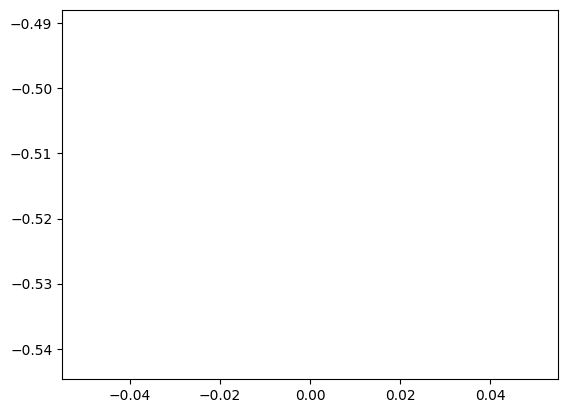

(10, 7518)

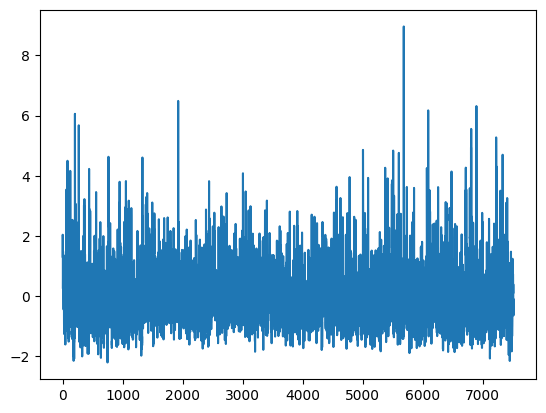

In [3]:
fp = torch.load("/Users/mds8301/Desktop/temp/dopamine_full_timeseries_array.pt")
fp = fp.detach().numpy()

fp_scaler = StandardScaler()
fp_data = fp[0:10,1:][:,::200][:10]
# fp_data = fp_scaler.fit_transform(fp_data)
plt.plot(fp_data[0])
fp_data.shape

In [28]:
sample_rate = 1070/200
second_10 = int(sample_rate)*10

In [29]:
window_size = second_10# 1 sec
# ws_3 = int(window_size/3)

ssa = SingularSpectrumAnalysis(window_size=window_size, groups  = 5)
fp_transform = ssa.fit_transform(fp_data)


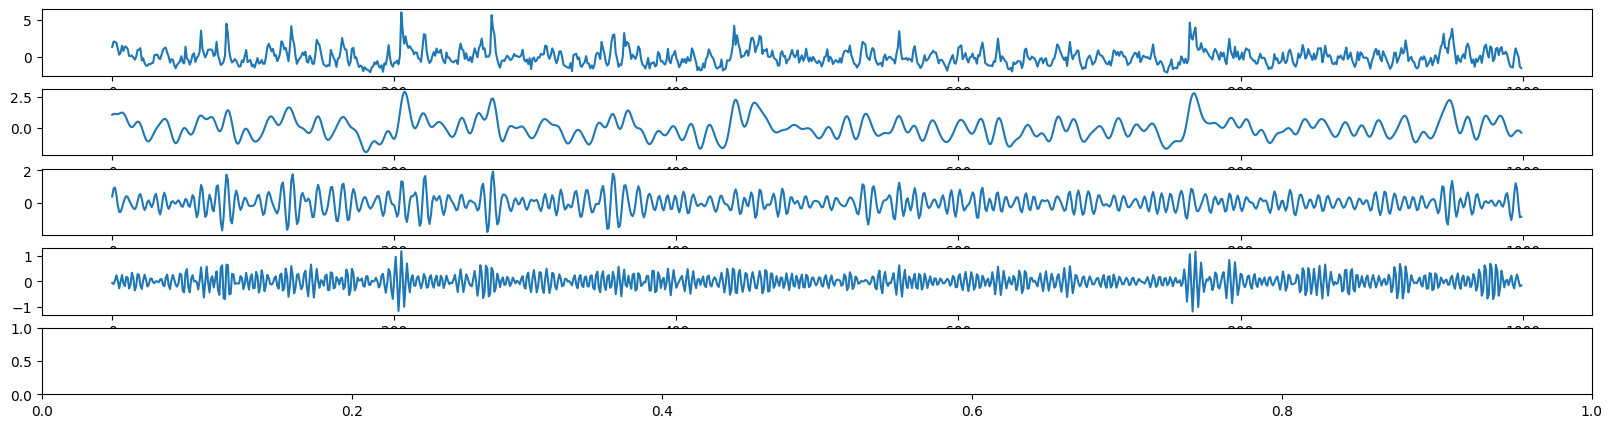

In [30]:
sample_idx = 0
sample_transform = fp_transform[sample_idx]
fig, ax = plt.subplots(nrows= 5, figsize = (20,5), sharey=False)
ax[0].plot(fp_data[sample_idx][:1000])
for i in range(3):
    ax[i+1].plot(sample_transform[i][:1000])

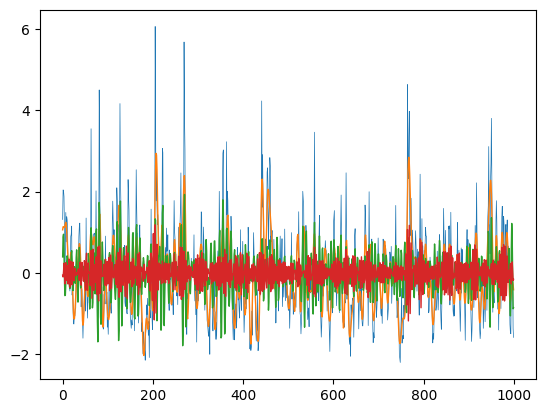

In [31]:
plt.plot(fp_data[sample_idx][:1000], lw=0.5)
for i in range(3):
    plt.plot(sample_transform[i][:1000], lw=1)

<Axes: xlabel='x', ylabel='y'>

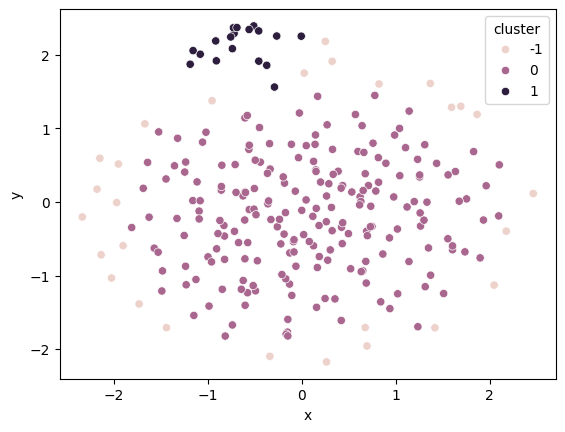

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

# Create a DataFrame from the embeddings


# Scale the data
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(tsne_emb)

# Choose the number of clusters
n_clusters = 20
min_samples = int(256/8)

# Create a K-Means instance
dbscan = DBSCAN(eps = 0.5, min_samples=10)

# Fit the K-Means model
dbscan.fit(scaled_embeddings)

# Get the cluster labels
cluster_labels = dbscan.labels_

# Visualize the clusters
# plt.show()
cluster_labels
embeddings_df = pd.DataFrame({
    'x': scaled_embeddings[:,0],
    'y': scaled_embeddings[:,1],
    'cluster': cluster_labels
})
sns.scatterplot(data = embeddings_df, x='x',y= 'y', hue = 'cluster')

In [ ]:
embeddings_df = pd.DataFrame({
    'x': scaled_embeddings[:,0],
    'y': scaled_embeddings[:,1],
    'cluster': cluster_labels
})

ImportError: cannot import name 'PCATransformer' from 'sktime.transformations.panel' (/Users/mds8301/anaconda3/envs/transphorm/lib/python3.11/site-packages/sktime/transformations/panel/__init__.py)